In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch

# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#opening data
import os
import pathlib
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

/Users/yashkarle/.conda/envs/soccer-ds-stats/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [5]:
#load data - store it in train dataframe
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', 'events_England.json') # delete #
with open(path) as f: # delete #
    data = json.load(f) # delete #
    
train = pd.DataFrame(data) # delete #
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


In [67]:
train.groupby('subEventName').count()

,eventId,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
subEventName,,,,,,,,,,,
,1558,1558,1558,1558,1558,1558,1558,1558,1558,1558,1558
Acceleration,4892,4892,4892,4892,4892,4892,4892,4892,4892,4892,4892
Air duel,37760,37760,37760,37760,37760,37760,37760,37760,37760,37760,37760
Ball out of the field,27331,27331,27331,27331,27331,27331,27331,27331,27331,27331,27331
Clearance,11784,11784,11784,11784,11784,11784,11784,11784,11784,11784,11784
Corner,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910
Cross,12251,12251,12251,12251,12251,12251,12251,12251,12251,12251,12251
Foul,7522,7522,7522,7522,7522,7522,7522,7522,7522,7522,7522
Free Kick,7279,7279,7279,7279,7279,7279,7279,7279,7279,7279,7279


In [6]:
shots = train.loc[train['subEventName'] == 'Shot']

#get shot coordinates as separate columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)

#calculate distance and angle
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, 
                          np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), 
                          np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)

#if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

In [8]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8451 entries, 46 to 643149
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eventId       8451 non-null   int64  
 1   subEventName  8451 non-null   object 
 2   tags          8451 non-null   object 
 3   playerId      8451 non-null   int64  
 4   positions     8451 non-null   object 
 5   matchId       8451 non-null   int64  
 6   eventName     8451 non-null   object 
 7   teamId        8451 non-null   int64  
 8   matchPeriod   8451 non-null   object 
 9   eventSec      8451 non-null   float64
 10  subEventId    8451 non-null   object 
 11  id            8451 non-null   int64  
 12  X             8451 non-null   float64
 13  Y             8451 non-null   float64
 14  C             8451 non-null   float64
 15  Distance      8451 non-null   float64
 16  Angle         8451 non-null   float64
 17  Goal          8451 non-null   object 
dtypes: float64(6), int64(5), 

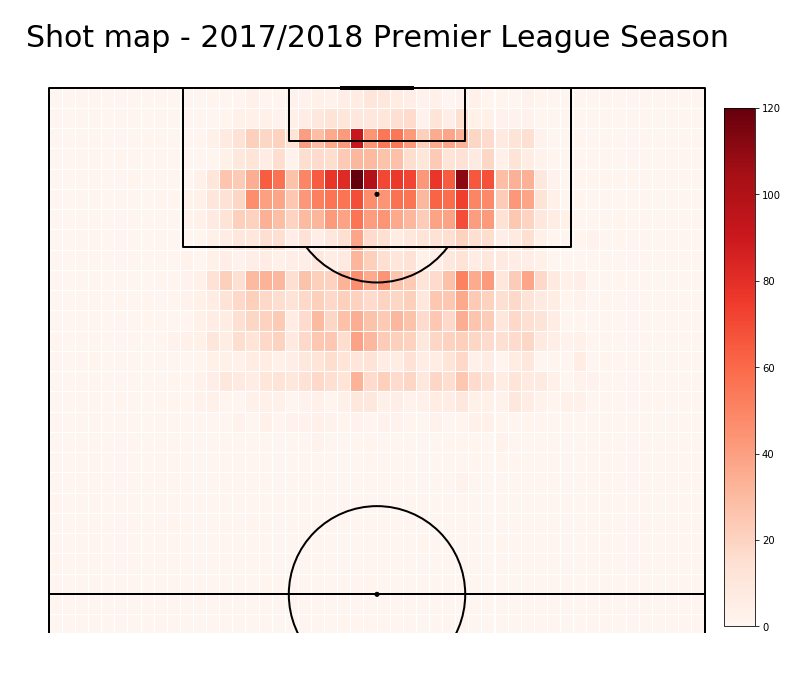

In [12]:
#plot pitch
pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105-shots.X, shots.Y, bins=50) #subtracting x from 105 but not y from 68 because of inverted Wyscout axis

#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth=0.01)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize=30)
plt.show()

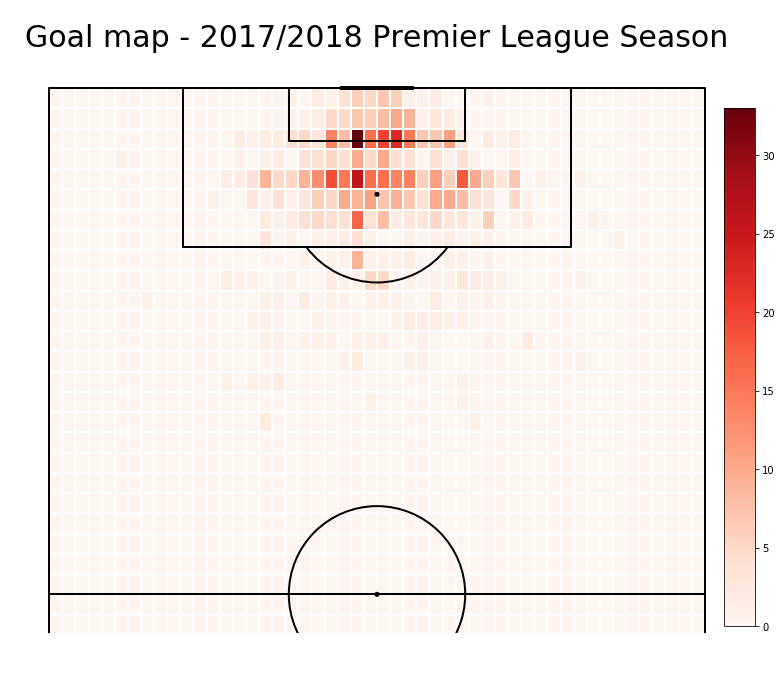

In [13]:
#take only goals
goals = shots.loc[shots["Goal"] == 1]

#plot pitch
pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105-goals.X, goals.Y, bins=50)

#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize=30)
plt.show()

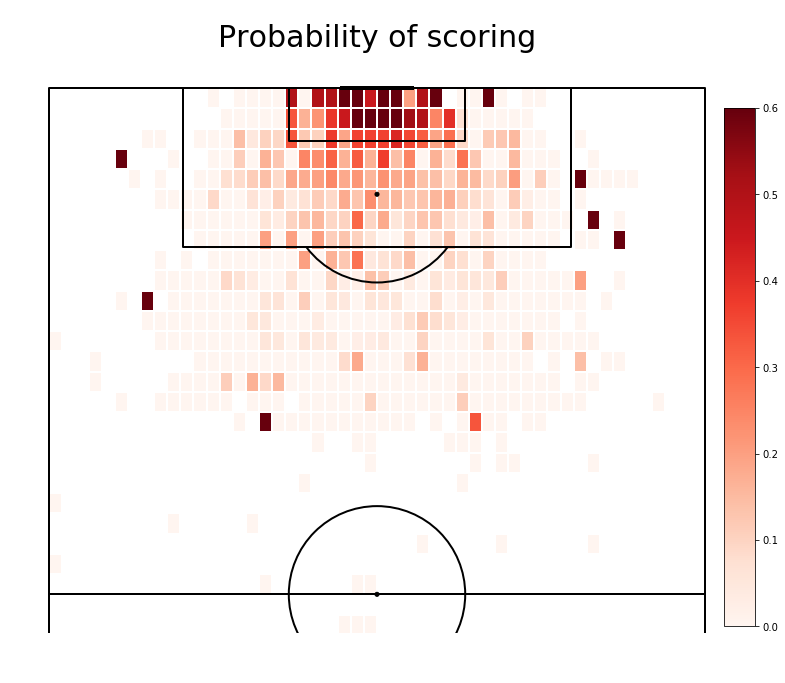

In [15]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

#normalize number of goals by number of shots
bin_statistic_shots = pitch.bin_statistic(105-shots.X, shots.Y, bins=50)
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic_shots["statistic"]

#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin=0, vmax=0.6)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Probability of scoring' , fontsize=30)
plt.show()

In [18]:
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])
#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
# angle bins
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2

In [24]:
angle

array([  0.  ,   3.75,   7.5 ,  11.25,  15.  ,  18.75,  22.5 ,  26.25,
        30.  ,  33.75,  37.5 ,  41.25,  45.  ,  48.75,  52.5 ,  56.25,
        60.  ,  63.75,  67.5 ,  71.25,  75.  ,  78.75,  82.5 ,  86.25,
        90.  ,  93.75,  97.5 , 101.25, 105.  , 108.75, 112.5 , 116.25,
       120.  , 123.75, 127.5 , 131.25, 135.  , 138.75, 142.5 , 146.25,
       150.  ])

In [22]:
midangle

array([  1.875,   5.625,   9.375,  13.125,  16.875,  20.625,  24.375,
        28.125,  31.875,  35.625,  39.375,  43.125,  46.875,  50.625,
        54.375,  58.125,  61.875,  65.625,  69.375,  73.125,  76.875,
        80.625,  84.375,  88.125,  91.875,  95.625,  99.375, 103.125,
       106.875, 110.625, 114.375, 118.125, 121.875, 125.625, 129.375,
       133.125, 136.875, 140.625, 144.375, 148.125])

In [29]:
#create model
test_model = smf.glm(formula="Goal ~ Angle" , data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

#get params
b=test_model.params
#calculate xG
xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180))

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2561.2
Date:                    Sun, 18 Sep 2022   Deviance:                       5122.5
Time:                            20:28:37   Pearson chi2:                 7.96e+03
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [32]:
xGprob

array([0.03131903, 0.03748555, 0.04481005, 0.0534862 , 0.06373015,
       0.07577899, 0.08988709, 0.10631961, 0.12534248, 0.14720831,
       0.17213788, 0.20029767, 0.23177438, 0.2665489 , 0.30447302,
       0.34525299, 0.38844446, 0.43346207, 0.47960536, 0.52609926,
       0.57214495, 0.61697394, 0.65989798, 0.70034799, 0.7378979 ,
       0.77227241, 0.80334022, 0.83109658, 0.85563942, 0.87714319,
       0.89583374, 0.91196623, 0.92580716, 0.93762083, 0.94765976,
       0.95615863, 0.96333087, 0.96936736, 0.97443649, 0.97868522])

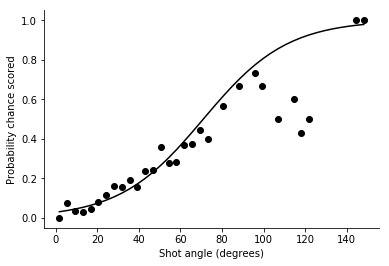

In [33]:
fig, ax = plt.subplots()
#plot data
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot line
ax.plot(midangle, xGprob, linestyle='solid', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [50]:
#creating extra variables
shots["D2"] = shots['Distance']**2
shots["X2"] = shots['X']**2
shots["C2"] = shots['C']**2
shots["AX"]  = shots['Angle']*shots['X']

# list the model variables you want here
model_variables = [
    'Angle',
    'Distance',
    'D2',
    # 'X','C', "X2", "C2", "AX"
]
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

In [51]:
model

'Angle + Distance + D2'

In [57]:
#fit the model
test_model = smf.glm(formula="Goal ~" + model, data=shots, family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8447
Model Family:                    Binomial   Df Model:                            3
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2499.5
Date:                    Sun, 18 Sep 2022   Deviance:                       4999.0
Time:                            20:50:39   Pearson chi2:                 8.34e+03
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [54]:
#return xG value for more general model
def calculate_xG(sh):
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG

#add an xG to my dataframe
xG=shots.apply(calculate_xG, axis=1)
shots = shots.assign(xG=xG)

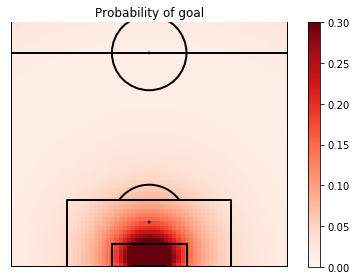

In [56]:
#Create a 2D map of xG
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['D2'] = x**2 + abs(y-68/2)**2
        # sh['X'] = x
        # sh['AX'] = x*a
        # sh['X2'] = x**2
        # sh['C'] = abs(y-68/2)
        # sh['C2'] = (y-68/2)**2

        pgoal_2d[x,y] =  calculate_xG(sh)

#plot pitch
pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.draw()
#plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder=1)
fig.colorbar(pos, ax=ax)

#make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [58]:
# Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1", data=shots, family=sm.families.Binomial()).fit()
print("Mcfaddens Rsquared", 1 - test_model.llf / null_model.llf)

Mcfaddens Rsquared 0.13680116154996846


In [60]:
np.arange(0, 1, 1 / numobs)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

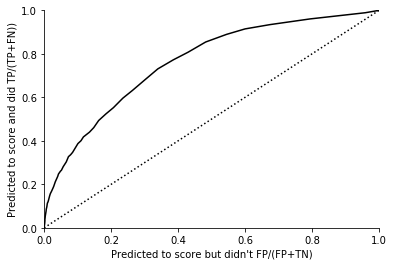

In [59]:
# ROC curve
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in shots.iterrows():
        if (shot['Goal'] == 1):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal'] == 0):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

fig, ax = plt.subplots()
ax.plot(FP/(FP+TN), TP/(TP+FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [62]:
shots.sort_values(by="xG", ascending=False)[:10]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,Y,C,Distance,Angle,Goal,X2,C2,AX,xG,D2
90690,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",11066,"[{'y': 47, 'x': 100}, {'y': 0, 'x': 0}]",2499774,Shot,1625,2H,816.732131,...,31.96,2.04,2.040000,3.141593,1,0.0000,4.1616,0.000000,0.857384,4.1616
611774,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25867,"[{'y': 51, 'x': 99}, {'y': 0, 'x': 0}]",2500080,Shot,1609,1H,827.211601,...,34.68,0.68,1.250960,2.565452,1,1.1025,0.4624,2.693725,0.811981,1.5649
520798,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",20857,"[{'y': 51, 'x': 99}, {'y': 100, 'x': 100}]",2500026,Shot,1619,2H,1621.981389,...,34.68,0.68,1.250960,2.565452,1,1.1025,0.4624,2.693725,0.811981,1.5649
14799,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",21160,"[{'y': 52, 'x': 99}, {'y': 0, 'x': 0}]",2499727,Shot,1644,2H,2879.337836,...,35.36,1.36,1.718168,2.507138,1,1.1025,1.8496,2.632495,0.792059,2.9521
112297,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",7914,"[{'y': 52, 'x': 99}, {'y': 0, 'x': 0}]",2499787,Shot,1627,1H,1258.115705,...,35.36,1.36,1.718168,2.507138,1,1.1025,1.8496,2.632495,0.792059,2.9521
246296,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",70086,"[{'y': 52, 'x': 99}, {'y': 0, 'x': 0}]",2499865,Shot,1625,2H,677.338249,...,35.36,1.36,1.718168,2.507138,1,1.1025,1.8496,2.632495,0.792059,2.9521
544957,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1216}, {'id'...",7945,"[{'y': 50, 'x': 98}, {'y': 0, 'x': 0}]",2500040,Shot,1609,2H,1969.954398,...,34.00,0.00,2.100000,2.099773,0,4.4100,0.0000,4.409523,0.720349,4.4100
430262,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1210}, {'id'...",38031,"[{'y': 50, 'x': 98}, {'y': 0, 'x': 0}]",2499973,Shot,1628,1H,2535.897798,...,34.00,0.00,2.100000,2.099773,0,4.4100,0.0000,4.409523,0.720349,4.4100
384806,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",8717,"[{'y': 50, 'x': 98}, {'y': 0, 'x': 0}]",2499946,Shot,1624,2H,120.715783,...,34.00,0.00,2.100000,2.099773,1,4.4100,0.0000,4.409523,0.720349,4.4100
508544,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",8958,"[{'y': 50, 'x': 98}, {'y': 100, 'x': 100}]",2500019,Shot,1627,2H,220.588472,...,34.00,0.00,2.100000,2.099773,1,4.4100,0.0000,4.409523,0.720349,4.4100


In [66]:
# players who had the highest xG in 2017/18 Premier League season
shots.groupby('playerId').agg({'xG':'sum'}).sort_values(by="xG", ascending=False)[:10]

,xG
playerId,
8717,21.121999
120353,14.960257
7905,12.555151
8325,12.250388
11066,11.879339
377071,11.311088
3324,10.972105
38031,10.277821
14703,9.560561
